# 기상자료에 따른 일사량 예측 (Machine Learning)
* EDA분석을 마친 train Data를 이용하여 기상자료에 따른 일사량 값을 예측한다.
* 값을 예측하는 알고리즘은 RandomForest을 사용한다.

# Load Dataset

In [298]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

### Read the Train Data 
* EDA 검사를 마친 Data를 읽어들인다.

In [299]:
# Train Data를 읽어들인다.
train = pd.read_csv("./train_EDA.csv",encoding='EUC-KR')
train.head()

,Unnamed: 0,지점,시간,평균기온(°C),평균풍속(m/s),평균운량,일조시간합,전천일사합,위도,경도
0,12,북춘천(93),1,-6.0,1.3,3.9,203.0,297.61,37.9475,127.7547
1,13,북춘천(93),2,-3.4,1.5,3.6,214.2,345.45,37.9475,127.7547
2,14,북춘천(93),3,7.0,1.8,4.6,204.3,434.45,37.9475,127.7547
3,15,북춘천(93),4,12.0,1.9,4.9,218.7,505.89,37.9475,127.7547
4,16,북춘천(93),5,17.2,1.7,5.4,233.2,577.58,37.9475,127.7547


### Read the Test Data
* Test할 Data를 읽어들인다.

In [300]:
# Test Data를 읽어들인다.
test = pd.read_csv("./test_ML.csv",encoding='EUC-KR')

# Feature Engineering
### Feature 기준
* count를 예측할 Feture : "위도", "경도", "평균기온(°C)", "평균운량", "일조시간합"


## Feature Selection
* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [301]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["시간"]

In [302]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [303]:
feature_names = ["위도","경도","시간"]

In [304]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(497, 3)


,위도,경도,시간
0,37.9475,127.7547,1
1,37.9475,127.7547,2
2,37.9475,127.7547,3
3,37.9475,127.7547,4
4,37.9475,127.7547,5


In [305]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(497, 3)


,위도,경도,시간
0,37.9475,127.7547,1
1,37.9475,127.7547,2
2,37.9475,127.7547,3
3,37.9475,127.7547,4
4,37.9475,127.7547,5


In [306]:
label_name = "전천일사합"

y_train = train[label_name]
y_train.head()

0    297.61
1    345.45
2    434.45
3    505.89
4    577.58
Name: 전천일사합, dtype: float64

## EVALUATION

### RNSLE 검증
과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다. 

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

* \\({n}\\) is the number of hours in the test set
* \\(p_i\\) is your predicted count
* \\(a_i\\) is the actual count
* \\(\log(x)\\) is the natural logarithm

* 좀 더 자세한 설명은 : [RMSLE cost function](https://www.slideshare.net/KhorSoonHin/rmsle-cost-function)

* 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
* 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.
* 값이 작을 수록 오류가 적다는 의미를 나타낸다.

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Logarithms.svg/456px-Logarithms.svg.png)
이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그

In [307]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### Cross Validation 교차 검증
* 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.
![image.png](https://www.researchgate.net/profile/Halil_Bisgin/publication/228403467/figure/fig2/AS:302039595798534@1449023259454/Figure-4-k-fold-cross-validation-scheme-example.png)
이미지 출처 : https://www.researchgate.net/figure/228403467_fig2_Figure-4-k-fold-cross-validation-scheme-example


* KFold 교차검증 
    * 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
    * 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
    * 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
    * 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
    * 이 과정을 마지막 폴드까지 반복한다.
    * 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [308]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## ALGORITHM
### RandomForest

In [309]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [310]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 2.67 s
Score= 0.15603


### Velidation 자료 검토
* ml을 예측하기 전에 Feature를 변경해 가면서 Score를 확인한다.
* "전천일사합"과 상관관계가 높은 자료등을 기준으로 가장 Score가 낮나올때까지 상관관계가 낮은 순서대로 Future에서 제외시킨다.

## Train / Predictions

In [311]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [312]:
# 예측
predictions = (model.predict(X_test))
print(predictions)

[ 293.725   343.6403  432.3838  509.0614  577.5678  609.3927  556.5467
  503.4045  394.7309  329.311   216.1577  219.3882  302.868   354.339
  444.8854  550.7466  567.3547  599.7814  568.9681  488.7951  372.6585
  361.8951  241.6868  242.0658  279.7634  331.1764  424.3299  505.3618
  571.8115  619.5643  588.827   524.5044  426.8816  348.2839  215.8406
  222.5409  606.363   622.0517  606.0807  605.0297  508.9747  456.8669
  259.515   228.8121  304.6324  357.8367  434.38    540.5486  549.8808
  603.2983  581.8274  471.8057  409.8127  391.4687  251.9417  257.5957
  308.7805  362.8285  442.3541  556.2288  573.4554  627.4144  603.4957
  488.5584  424.68    408.3914  267.1615  271.6187  191.9198  297.1374
  441.8119  512.9849  564.9157  597.8717  575.8411  524.5542  465.889
  404.9026  262.9478  253.4569  184.9997  268.2223  444.0544  516.3255
  572.8914  608.7367  618.9587  555.574   460.9777  409.4908  268.848
  255.4113  298.5931  344.0756  450.8472  525.0615  581.3286  619.8953
  621.837

[Text(0.5,1,'test')]

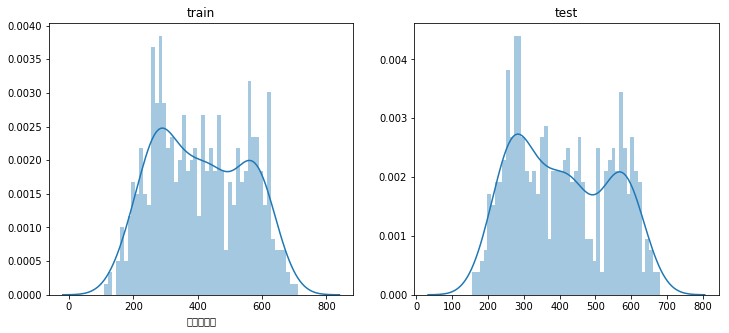

In [313]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [314]:
test_ml = test
test_ml["전천일사합"] = predictions

In [315]:
test_ml.to_csv ( "./predict_ML.csv" )

In [316]:
test_ml.head()

,지점,시간,전천일사합,위도,경도
0,북춘천(93),1,293.7250,37.9475,127.7547
1,북춘천(93),2,343.6403,37.9475,127.7547
2,북춘천(93),3,432.3838,37.9475,127.7547
3,북춘천(93),4,509.0614,37.9475,127.7547
4,북춘천(93),5,577.5678,37.9475,127.7547


In [317]:
diff_rate = (test_ml["전천일사합"]- train["전천일사합"])/train["전천일사합"]*100
print(diff_rate.describe())

count    497.000000
mean       0.948404
std        6.862446
min      -19.035315
25%       -2.271568
50%       -0.123705
75%        2.420246
max       47.929958
Name: 전천일사합, dtype: float64
